In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.systems import LowRankRNN
from dsn.util.dsn_util import get_savedir
from dsn.util.plot_util import assess_constraints, plot_opt, dsn_pairplots, pairplot, lin_reg_plot
from tf_util.stat_util import approx_equal

/Users/sbittner/anaconda/envs/dsn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
/Users/sbittner/anaconda/envs/dsn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
EPS = 1e-16

# normalizing flow layer architecture
TIF_flow_type = 'PlanarFlowLayer'
# number of layers
nlayers = 10
mult_and_shift = 'post'
arch_dict = {'D':5, \
             'latent_dynamics':None, \
             'mult_and_shift':mult_and_shift, \
             'TIF_flow_type':TIF_flow_type, \
             'repeats':nlayers}

# multivariate normal initialization variance
sigma_init = 1.0
#sigma_init = 3.16
c_init_order = 1

dirstr = 'rank1_ND'

# create an instance of the V1_circuit system class
"""fixed_params = fixed_params = {'MI':0.0, \
                'Sm':1.0, \
                'Sn':1.0, \
                'SmI':0.0, \
                'Sperp':0.0}"""
fixed_params = fixed_params = {'MI':0.0, \
                'SmI':0.0, \
                'Sperp':0.0}

behavior_type = 'ND'
means = np.array([0.6]);
variances = np.array([0.01]);
    
behavior = {'type':behavior_type, \
            'means':means, \
            'variances':variances}

# set model options
model_opts = {'rank':1, 'input_type':'input'}

solve_its = 25
solve_eps = 0.5

system = LowRankRNN(fixed_params, behavior, model_opts=model_opts, \
                    solve_its=solve_its, solve_eps=solve_eps)

lr_order = -3

ind  0 behavior checked


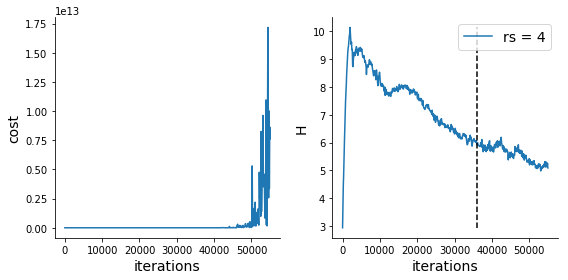

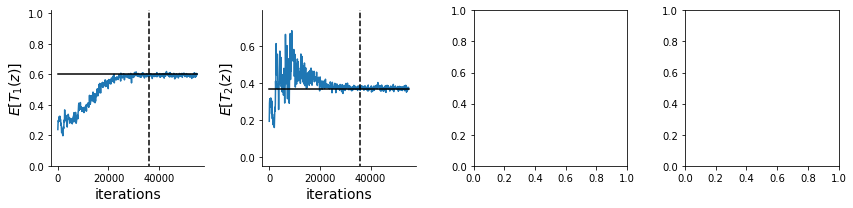

p values
0


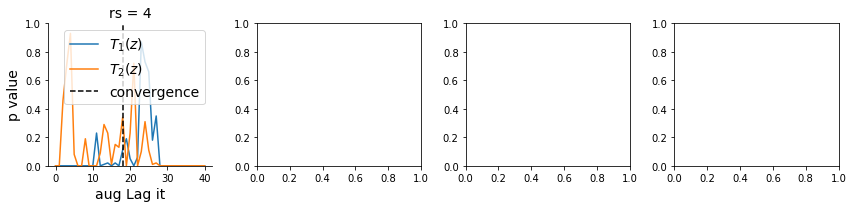

In [3]:
start_rs = 4
num_rs = 1

random_seeds = np.arange(start_rs, num_rs+start_rs)


basedir = '/Users/sbittner/Documents/dsn/dsn/'
fnames = []
legendstrs = []
for i in range(num_rs):
    random_seed = random_seeds[i]
    dsndir = basedir + get_savedir(system, arch_dict, sigma_init, lr_order, c_init_order, random_seed, dirstr)
    fname = dsndir + 'opt_info.npz'
    fnames.append(fname)
    legendstrs.append('rs = %d' % random_seed)
    npzfile = np.load(fname)
    behavior_i = npzfile['behavior'][()]
    assert(approx_equal(behavior_i['means'], behavior['means'], EPS))
    assert(approx_equal(behavior_i['variances'], behavior['variances'], EPS))
    print('ind ', i, 'behavior checked')
    
figs, AL_final_its, p_values = plot_opt(fnames, legendstrs, con_method='1', frac_samps=0.5)

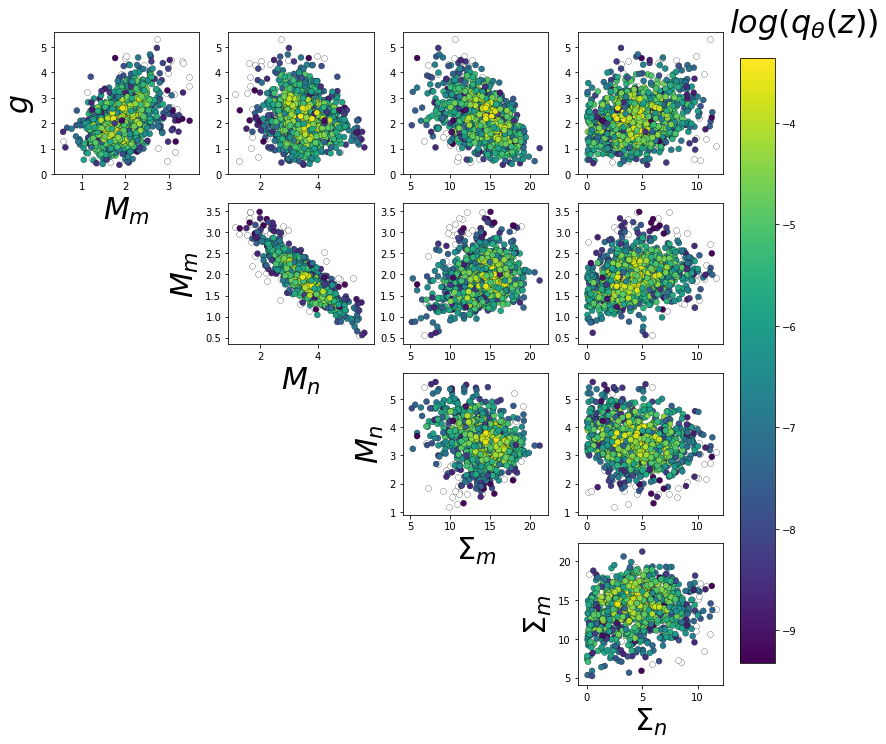

[<Figure size 864x864 with 17 Axes>]

In [4]:
pfname = 'images/rank1_ND_DSN_Z.png'
dsn_pairplots(fnames, 'Zs', system, system.D, f_str='identity', \
              c_str='log_q_z', legendstrs=[], AL_final_its=AL_final_its, \
              fontsize=30, ellipses=False, tri=True, pfname=pfname)

In [57]:
AL_final_it = AL_final_its[0]
fname = fnames[0]
npzfile = np.load(fname)
Zs = npzfile['Zs'][AL_final_it]
T_xs = npzfile['T_xs'][AL_final_it]

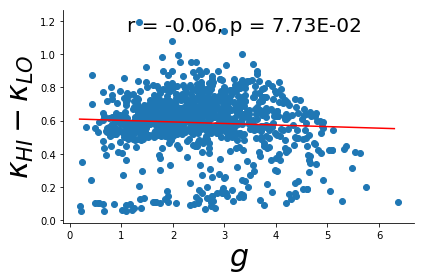

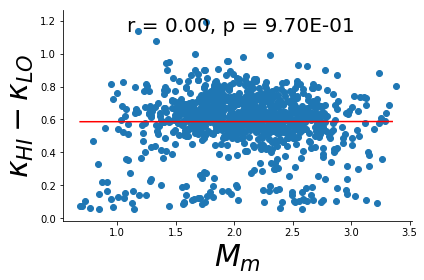

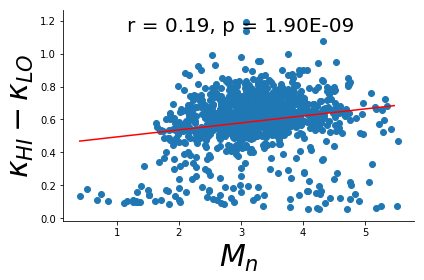

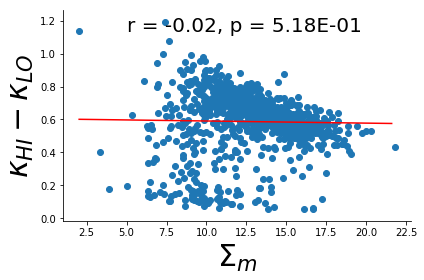

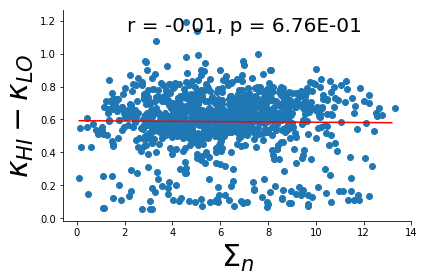

In [58]:
fontsize = 30
    
z_inds = [0,1,2,3,4]
T_inds = [0,0,0,0,0]
num_inds = len(z_inds)
for i in range(num_inds):
    z_ind = z_inds[i]
    T_ind = T_inds[i]
    lin_reg_plot(Zs[:,z_ind], T_xs[:,T_ind], system.z_labels[z_ind], system.T_x_labels[T_ind], \
                 pfname='images/corr%d' % (i+1), fontsize=fontsize)

In [59]:
Zs.shape

(1000, 5)

In [65]:
DTYPE = tf.float64
num_conds = 2
M = Zs.shape[0]
c_LO = 0.25
c_HI = 0.75

Z_tf = tf.placeholder(dtype=DTYPE, shape=Zs.shape)

mu_init = -5.0 * tf.ones((num_conds*M,), dtype=DTYPE)
kappa_init = -5.0 * tf.ones((num_conds*M,), dtype=DTYPE)
delta_0_init = 5.0 * tf.ones((num_conds*M,), dtype=DTYPE)
delta_inf_init = 4.0 * tf.ones((num_conds*M,), dtype=DTYPE)

MI = tf.zeros((num_conds*M,), dtype=DTYPE)
SmI = tf.zeros((num_conds*M,), dtype=DTYPE)
SnI = tf.concat((c_LO*tf.ones((M,), dtype=DTYPE), 
                 c_HI*tf.ones((M,), dtype=DTYPE)), 
                 axis=0)
Sperp = tf.zeros((num_conds*M,), dtype=DTYPE)

g = tf.tile(Z_tf[:,0], [2])
Mm = tf.tile(Z_tf[:,1], [2])
Mn = tf.tile(Z_tf[:,2], [2])
Sm = tf.tile(Z_tf[:,3], [2])
Sn = tf.tile(Z_tf[:,4], [2])

solve_its = 300
eps = 0.8
           

In [66]:
from dsn.util.tf_DMFT_solvers import rank1_input_chaotic_solve
mu, kappa, delta_0, delta_inf, xs = rank1_input_chaotic_solve(
    mu_init,
    kappa_init,
    delta_0_init,
    delta_inf_init,
    g,
    Mm,
    Mn,
    MI,
    Sm,
    Sn,
    SmI,
    SnI,
    Sperp,
    num_its=solve_its,
    eps=solve_eps,
    gauss_quad_pts=50,
    db=True)

In [67]:
with tf.Session() as sess:
    _mu, _kappa, _delta_0, _delta_inf, _xs = sess.run([mu, kappa, delta_0, delta_inf, xs], {Z_tf:Zs})

_delta_T = _delta_0 - _delta_inf

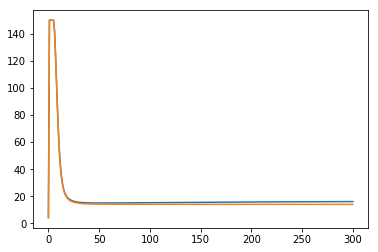

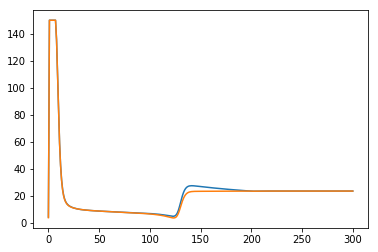

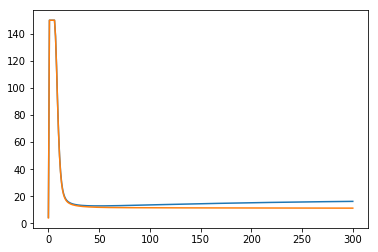

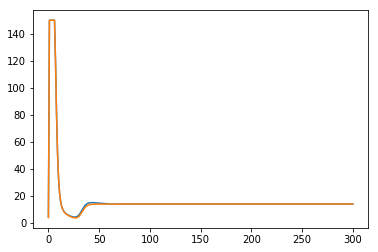

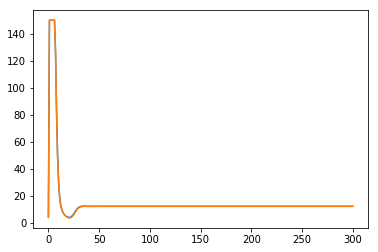

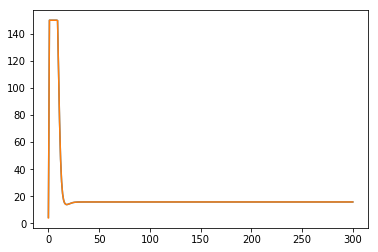

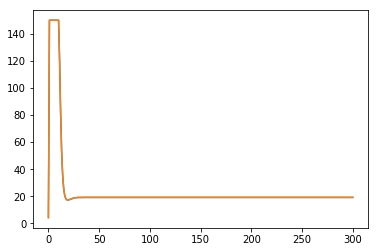

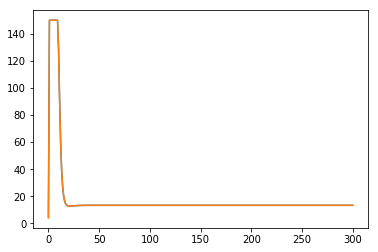

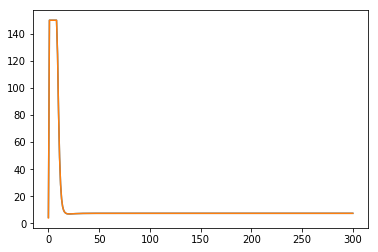

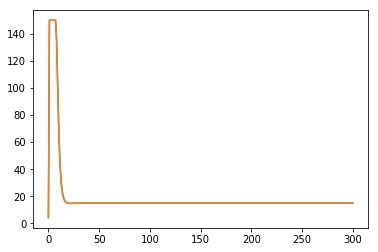

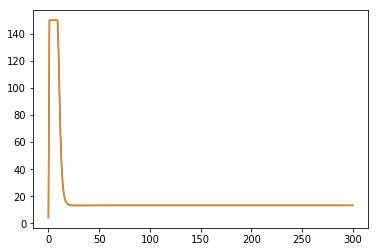

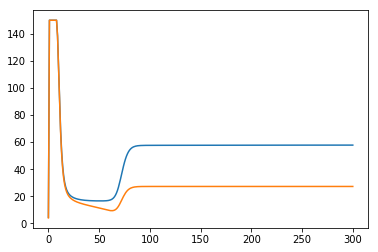

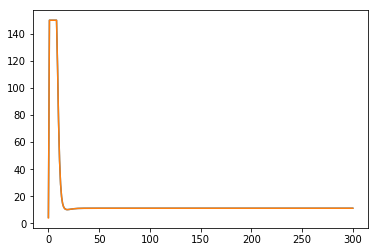

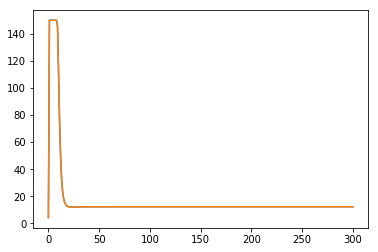

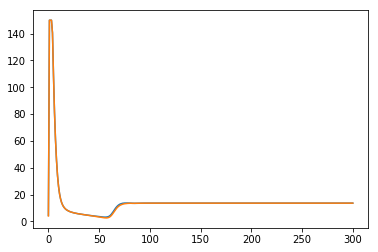

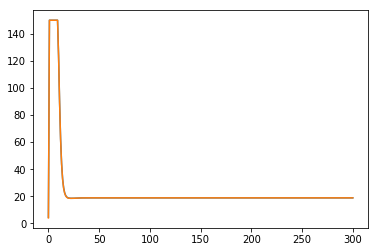

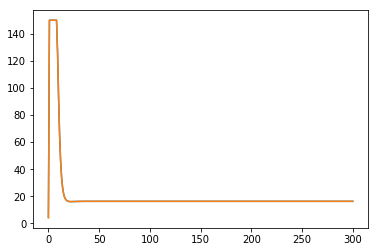

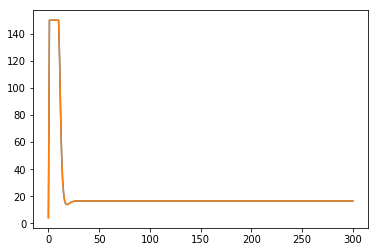

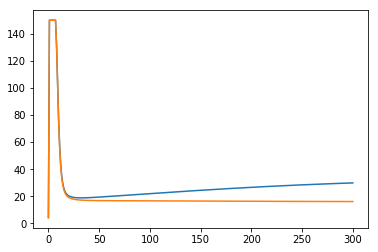

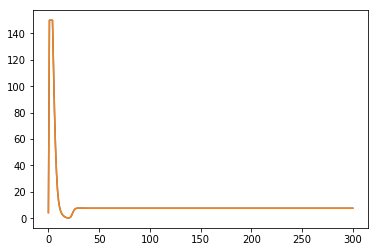

In [68]:
for i in range(20):
    plt.figure()
    plt.plot(_xs[i,2:,:].T)
    plt.show()

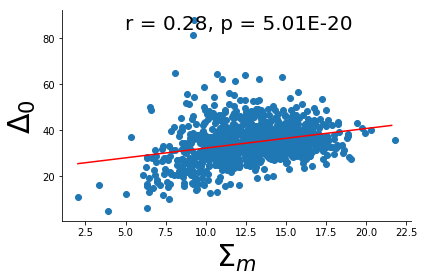

In [73]:
_delta_T_avg = (_delta_T[:M] + _delta_T[M:]) / 2
lin_reg_plot(Zs[:,3], _delta_0[M:], r'$\Sigma_m$', r'$\Delta_0$', \
                 pfname='images/corr%d' % (i+1), fontsize=fontsize)

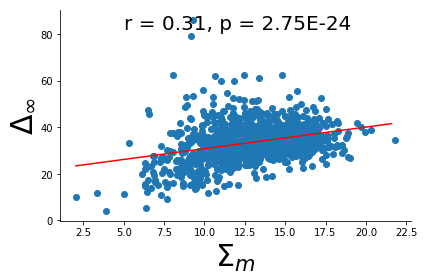

In [80]:
lin_reg_plot(Zs[:,3], _delta_inf[M:], r'$\Sigma_m$', r'$\Delta_\infty$', \
                 pfname='images/corr%d' % (i+1), fontsize=fontsize)

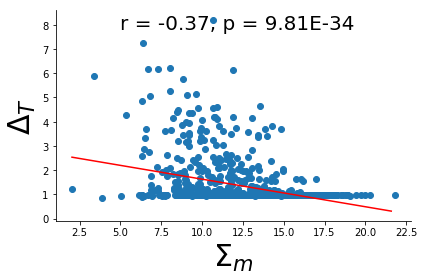

In [92]:
lin_reg_plot(Zs[:,3], _delta_T_avg, r'$\Sigma_m$', r'$\Delta_T$', \
                 pfname='images/corr%d' % (i+1), fontsize=fontsize)